# Interactive predictive model fitting for classifying case/control using pathway data. 

Quang Nguyen   
Last updated 2022-04-27

In [77]:
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from skbio.stats.composition import clr

In [2]:
np.random.seed(160497)

In [21]:
feat = pd.read_csv("../data/pred_pathway_ibd_feat.csv", index_col=0)
lab = pd.read_csv("../data/pred_pathway_ibd_metadata.csv", index_col=0)

In [22]:
feat.head()

,UNMAPPED,UNINTEGRATED,PWY-6737: starch degradation V,PWY-1042: glycolysis IV (plant cytosol),PWY-5686: UMP biosynthesis,PWY-6163: chorismate biosynthesis from 3-dehydroquinate,PWY-6386: UDP-N-acetylmuramoyl-pentapeptide biosynthesis II (lysine-containing),ILEUSYN-PWY: L-isoleucine biosynthesis I (from threonine),PWY-7111: pyruvate fermentation to isobutanol (engineered),VALSYN-PWY: L-valine biosynthesis,...,PWY-6148: tetrahydromethanopterin biosynthesis,P261-PWY: coenzyme M biosynthesis I,PWY-5079: L-phenylalanine degradation III,PWY-6957: mandelate degradation to acetyl-CoA,P101-PWY: ectoine biosynthesis,"PWY-6309: L-tryptophan degradation XI (mammalian, via kynurenine)",LEU-DEG2-PWY: L-leucine degradation I,PWY-7373: superpathway of demethylmenaquinol-6 biosynthesis II,PWY-7420: monoacylglycerol metabolism (yeast),ALL-CHORISMATE-PWY: superpathway of chorismate metabolism
SKST006_6_G102964,0.205630,0.750061,0.000681,0.000610,0.000576,0.000564,0.000551,0.000551,0.000551,0.000551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SKST006_7_G102965,0.209946,0.742283,0.000639,0.000641,0.000574,0.000513,0.000592,0.000542,0.000542,0.000542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SKST006_4_G102962,0.187781,0.766908,0.000628,0.000592,0.000553,0.000500,0.000542,0.000517,0.000517,0.000517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SKST006_5_G102963,0.218590,0.737545,0.000688,0.000685,0.000526,0.000483,0.000582,0.000519,0.000519,0.000519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SKST006_2_G102960,0.232418,0.720824,0.000684,0.000644,0.000595,0.000596,0.000592,0.000604,0.000604,0.000604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
lab.head()

,study_name,disease,study_condition
SKST006_6_G102964,HallAB_2017,IBD,IBD
SKST006_7_G102965,HallAB_2017,IBD,IBD
SKST006_4_G102962,HallAB_2017,IBD,IBD
SKST006_5_G102963,HallAB_2017,IBD,IBD
SKST006_2_G102960,HallAB_2017,IBD,IBD


In [30]:
np.array_equal(feat.index.values, lab.index.values)

True

In [25]:
rf = RandomForestClassifier(n_estimators=500, max_features='sqrt')

In [43]:
X = feat.to_numpy()
print(X.shape)
Y = lab.loc[:,"study_condition"].to_numpy()
print(Y.shape)

(2881, 510)
(2881,)


In [57]:
acc = []
imp = []
kf = KFold(n_splits=2)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    rf.fit(X_train, Y_train)
    yhat = rf.predict(X_test)
    imp.append(permutation_importance(
        rf, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
    ))
    acc.append(accuracy_score(y_true=Y_test,y_pred=yhat))
    


TRAIN: [1441 1442 1443 ... 2878 2879 2880] TEST: [   0    1    2 ... 1438 1439 1440]
TRAIN: [   0    1    2 ... 1438 1439 1440] TEST: [1441 1442 1443 ... 2878 2879 2880]


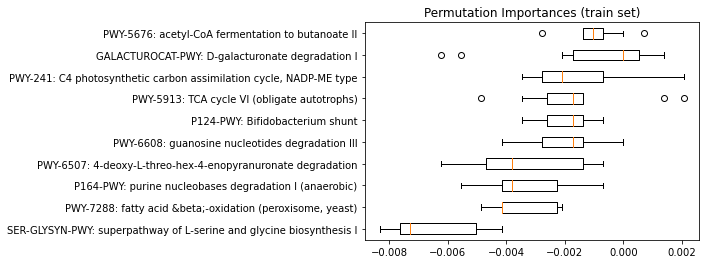

In [76]:
sorted_idx = imp[0].importances_mean.argsort()[range(0,10)]

fig, ax = plt.subplots()
ax.boxplot(
    imp[0].importances[sorted_idx].T, vert=False, 
    labels=feat.columns[sorted_idx]
)
ax.set_title("Permutation Importances (train set)")
plt.show()

In [71]:
print(len(imp[0].importances[sorted_idx].T[range(0,10)]))
print(len(feat.columns[sorted_idx][range(0,10)]))

10
10


In [73]:
sorted_idx

array([ 72, 286, 139, 158, 101, 228, 232, 227, 155, 181, 180, 212,  50,
       122, 349, 254, 196, 304,  70, 202,   1, 127, 204, 130, 280,  63,
        60,  91, 175, 152, 201, 154, 214,  79, 271, 190, 371, 302,  68,
       300,  56, 222,  65, 237, 253, 361, 367, 223, 345, 272, 265, 385,
       372, 354, 281, 282, 398, 321, 215,  49, 113,  78, 199,  53, 273,
       187, 479, 348, 347, 480, 335, 333, 331, 330, 329, 325, 481, 317,
       311, 332, 478, 454, 307, 471, 370, 369, 472, 363, 362, 473, 352,
       360, 357, 356, 474, 475, 476, 477, 353, 358, 482, 299, 484, 496,
       508, 497, 498, 499, 500, 248, 501, 502, 231, 503, 504, 505, 506,
       507, 495, 483, 494, 274, 485, 470, 298, 486, 487, 297, 296, 294,
       288, 488, 489, 490, 491, 492, 275, 493, 469, 375, 455, 439, 438,
       437, 436, 435, 434, 433, 432, 429, 461, 428, 427, 426, 425, 424,
       440, 423, 441, 443, 456, 453, 452, 457, 451, 458, 450, 449, 448,
       459, 447, 460, 446, 445, 444, 442, 422, 421, 420, 465, 39